In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from IPython.display import Markdown, Image

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

Utils

In [3]:
def get_cm_based_measures(conf_matrix):
    TN = conf_matrix[0][0]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    
    # TPR = TP / TP + FN
    TPR = round(TP / (TP + FN), 6)
    # TNR = TN / TN + FP
    TNR = round(TN / (TN + FP), 6)
    # FPR = FP / TN + FP
    FPR = round(FP / (TN + FP), 6)
    # FNR = FN / TP + FN
    FNR = round(FN / (TP + FN), 6)
    # accuracy (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # precision = TP / TP + FP
    precision = TP / (TP + FP)
    # recall = TP / TP + FN
    recall_pos = round(TP / (TP + FN), 6)
    recall_neg = round(TN / (TN + FP), 6)
    # avg class accuracy
    avg_acc = 1/2*(recall_pos+recall_neg)
    
    print( f'TPR: {TPR}   TNR: {TNR}   FPR: {FPR}   FNR: {FNR}   Accuracy: {accuracy}   Avg. Class Acc: {avg_acc}')

### Dataset

In [4]:
# importing the dataset
data_path = 'data/'
file_name = 'titanic_preproc_df.csv'
titanic_df = pd.read_csv(data_path+file_name)
display(titanic_df.shape)
titanic_df.info()
titanic_df.head()

(891, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Salutation  891 non-null    int64
 3   FareBand    891 non-null    int64
 4   AgeBand     891 non-null    int64
 5   FSizeBand   891 non-null    int64
dtypes: int64(6)
memory usage: 41.9 KB


,Survived,Pclass,Salutation,FareBand,AgeBand,FSizeBand
0,0,3,0,1,2,2
1,1,1,3,3,4,2
2,1,3,4,4,2,1
3,1,1,3,3,3,2
4,0,3,0,4,3,1


Default parameters in sklearn: *AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)*

--> base_estimator is DecisionTreesClassifier by default

The most relevant hyperparameters are the number of trees (n_estimators) which is 50 by default, and the learning rate which is 1.0 by default. In addition, the depth of the trees (DecisionTreesClassifier trees) is relevant as well.

In [11]:
# finding best combination of n_estimators, max_depth, and learning_rate

# grid or params
grid_param = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], 
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
              'base_estimator__max_depth': [1, 2, 3]}

# base estimator for AdaBoost
base = DecisionTreeClassifier()

grid_cv = GridSearchCV(AdaBoostClassifier(base), param_grid=grid_param, n_jobs=-1) # cv=5 and scoring is based on accuracy by default
grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1.0],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350,
                                          400]})

In [12]:
print("Best params: accuracy %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best params: accuracy 0.848422 using {'base_estimator__max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 50}


In [13]:
# top 5 combination of params
df = pd.DataFrame(grid_cv.cv_results_)
df = df.sort_values('rank_test_score')[['param_base_estimator__max_depth', 'param_learning_rate', 'param_n_estimators', 'params', 'mean_test_score','std_test_score','rank_test_score']]
df.iloc[:5,]

,param_base_estimator__max_depth,param_learning_rate,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score
88,2,0.2,50,"{'base_estimator__max_depth': 2, 'learning_rat...",0.848422,0.040010,1
120,2,0.6,50,"{'base_estimator__max_depth': 2, 'learning_rat...",0.844701,0.052189,2
160,3,0.1,50,"{'base_estimator__max_depth': 3, 'learning_rat...",0.844683,0.045008,3
81,2,0.1,100,"{'base_estimator__max_depth': 2, 'learning_rat...",0.844683,0.043428,3
82,2,0.1,150,"{'base_estimator__max_depth': 2, 'learning_rat...",0.842814,0.050420,5


#### Model in Test Data

Accuracy: 0.8291
Average class accuracy: 0.8046
TPR: 0.687943   TNR: 0.921296   FPR: 0.078704   FNR: 0.312057   Accuracy: 0.8291316526610645   Avg. Class Acc: 0.8046195


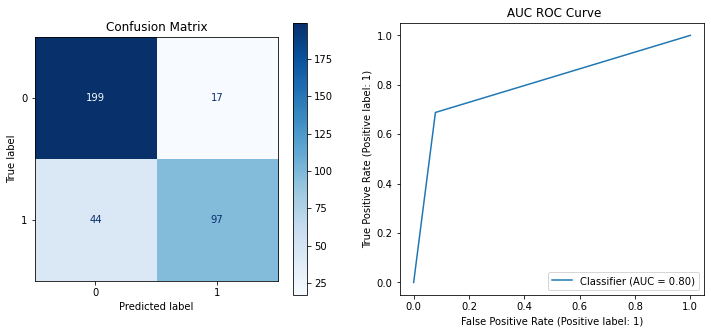

#### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       216
           1       0.85      0.69      0.76       141

    accuracy                           0.83       357
   macro avg       0.83      0.80      0.81       357
weighted avg       0.83      0.83      0.83       357



In [14]:
# predicting using the best params found before
predicted_Y_test = grid_cv.predict(X_test)

display(Markdown("#### Model in Test Data"))
# metrics
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

# average class accuracy score
avg_acc_test = metrics.balanced_accuracy_score(y_test, predicted_Y_test)
print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

# confusion matrix-based performance measures
label_class_set = grid_cv.classes_
CM = metrics.confusion_matrix(y_test, predicted_Y_test, labels=label_class_set)
get_cm_based_measures(CM)

# plotting results -----------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'hspace': 0.3})

# plot confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay(CM).plot(cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# calculate and plot ROC AUC curve
roc_disp = metrics.RocCurveDisplay.from_predictions(y_test, predicted_Y_test, ax=ax[1])
ax[1].set_title(" AUC ROC Curve")

plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))